# Recommender System - Model Development
This notebook demonstrates building a recommendation system on the Amazon Reviews 2023 dataset. It includes data loading, preprocessing, model training, evaluation, and generating sample recommendations. The dataset is sourced from the Hugging Face datasets library [Amazon Reviews 2023](https://huggingface.co/datasets/McAuley-Lab/Amazon-Reviews-2023) based on paper [Bridging Language and Items for Retrieval and Recommendation (2024)](
https://doi.org/10.48550/arXiv.2403.03952
).

In [16]:
import os
import random
import numpy as np
import pandas as pd
import time
import gc
import matplotlib.pyplot as plt
from collections import defaultdict

os.environ["HF_HOME"] = "D:/Python Projects/recommendation_system"
os.environ["HF_DATASETS_CACHE"] = "D:/Python Projects/recommendation_system/recsys/data"
os.environ["TRANSFORMERS_CACHE"] = "D:/Python Projects/recommendation_system/recsys/models"

# os.environ["HF_HOME"] = "E:/Python Scripts/recsys"
# os.environ['HF_DATASETS_CACHE'] = "E:/Python Scripts/recsys/data"
# os.environ['TRANSFORMERS_CACHE'] = "E:/Python Scripts/recsys/models"

os.environ['CUDA_LAUNCH_BLOCKING'] = "1"

import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from sklearn.preprocessing import LabelEncoder
from datasets import load_dataset, Features, Value
from tqdm import tqdm
from tensorboardX import SummaryWriter

In [17]:
SEED = 42
def set_seed(seed=SEED):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)

set_seed(SEED)
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
print("DEVICE:", DEVICE)

DEVICE: cuda


## Loading the dataset
The dataset is loaded from the Hugging Face datasets library, Amazon Reviews 2023.

In [57]:
USE_HF = True
HF_DATASET = "McAuley-Lab/Amazon-Reviews-2023"
HF_DOMAIN = "Books"

def load_amazon_reviews(domain, save_dir="data", max_items=None, seed=SEED):
    os.makedirs(save_dir, exist_ok=True)
    filepath = f"{save_dir}/amazon_reviews_{domain}.csv"

    if not os.path.exists(filepath):
        print(f"File {filepath} not found. Downloading dataset for domain '{domain}'...")
        ds = load_dataset(
            "McAuley-Lab/Amazon-Reviews-2023",
            f"raw_review_{domain}",
            split="full",
            trust_remote_code=True,
        )

        ds = ds.select_columns(["user_id", "parent_asin", "rating", "timestamp"])
        ds = ds.rename_columns({"user_id": "user", "parent_asin": "item"})
        ds = ds.cast(Features({
            "user": Value("string"),
            "item": Value("string"),
            "rating": Value("float32"),
            "timestamp": Value("int64"),
        }))

        df = ds.to_pandas()
        df.insert(3, "domain", domain)
        df.to_csv(f"{save_dir}/amazon_reviews_{domain}.csv", index=False)
        print(f"Saved amazon_reviews_{domain}.csv to {save_dir}/")

    final_df = pd.read_csv(filepath)
    if max_items is not None:
        k = min(max_items, len(final_df))
        final_df = final_df.sample(n=k, random_state=seed).reset_index(drop=True)
    print(f"Loaded {filepath} with {len(final_df)} rows.")
    return final_df

df = load_amazon_reviews(HF_DOMAIN, save_dir="data", max_items=10_000_000, seed=SEED)
print(f"Loaded {len(df)} rows from {HF_DOMAIN} domain.")

Loaded data/amazon_reviews_Books.csv with 10000000 rows.
Loaded 10000000 rows from Books domain.


In [58]:
df.head()

,user,item,rating,domain,timestamp
0,AEADNN27WH7SOS6QFJYFJSITC7FQ,1847252370,5.0,Books,1358572717000
1,AETNE77ZXSJST5PWIXABKOXPLNNA,1904563643,5.0,Books,1571550861633
2,AF6Q3Y4FWKXXMROUWKMHGHD35Z6Q,B09L91L8WJ,5.0,Books,1636685186681
3,AH7JAKZVXUS6YK3EUDVBPZ5QQO4A,0999877003,5.0,Books,1674101452159
4,AFAA3ZUA3ERM2MGCR3WP3VADLXYA,0393624587,5.0,Books,1563584263663


## Preprocessing the dataset
- Make it implicit by considering all ratings as positive interactions.
- Filter out users and items with less than 5 interactions.
- Create a mapping of user and item IDs to indices.

In [59]:
# Make implicit dataset, filter users/items with less than k interactions
def preprocess_dataset(df, min_user_interactions=5, min_item_interactions=5):
    df["label"] = 1.0 # Make it implicit
    user_counts = df["user"].value_counts()
    item_counts = df["item"].value_counts()
    valid_users = user_counts[user_counts >= min_user_interactions].index
    valid_items = item_counts[item_counts >= min_item_interactions].index
    df = df[df["user"].isin(valid_users) & df["item"].isin(valid_items)].copy()
    print("After interactions filtering:", len(df), "rows,", df["user"].nunique(), "users,", df["item"].nunique(), "items")
    return df

def label_encoder(df):
    df_enc = df.copy()
    user_enc = LabelEncoder()
    item_enc = LabelEncoder()
    df_enc["user_id"] = user_enc.fit_transform(df_enc["user"])
    df_enc["item_id"] = item_enc.fit_transform(df_enc["item"])
    return df_enc, user_enc, item_enc

filtered_df = preprocess_dataset(df, min_user_interactions=20, min_item_interactions=20)
df_encoded, user_enc, item_enc = label_encoder(filtered_df)

After interactions filtering: 318168 rows, 24942 users, 53240 items


In [60]:
def calculate_data_sparsity(df):
    num_users = df["user"].nunique()
    num_items = df["item"].nunique()
    num_interactions = len(df)
    density = num_interactions / (num_users * num_items)
    sparsity = 1 - density

    print(f"Number of users: {num_users}")
    print(f"Number of items: {num_items}")
    print(f"Number of interactions: {num_interactions}")
    print(f"-" * 30)
    print(f"Interaction Matrix Density: {density:.6f}")
    print(f"Interaction Matrix Sparsity: {sparsity:.6f}")

calculate_data_sparsity(df_encoded)

Number of users: 24942
Number of items: 53240
Number of interactions: 318168
------------------------------
Interaction Matrix Density: 0.000240
Interaction Matrix Sparsity: 0.999760


In [61]:
def loo_split(df):
    df = df.sort_values(["user_id", "timestamp"])
    train_rows, val_rows, test_rows = [], [], []

    for uid, group in df.groupby("user_id", sort=False):
        g = group.sort_values("timestamp")
        if len(g) < 3:
            train_rows.append(g)
            continue
        test_rows.append(g.iloc[[-1]]) # Last interaction as test
        val_rows.append(g.iloc[[-2]]) # Second last interaction as validation
        train_rows.append(g.iloc[:-2]) # All but last two as training

    train_df = pd.concat(train_rows, ignore_index=True)
    val_df = pd.concat(val_rows, ignore_index=True)
    test_df = pd.concat(test_rows, ignore_index=True)

    return train_df, val_df, test_df

train_df, val_df, test_df = loo_split(df_encoded)
print(f"Train/Validation/Test split: {len(train_df)}, {len(val_df)}, {len(test_df)}")

Train/Validation/Test split: 273698, 22235, 22235


## Building the dataset with negative sampling

In [62]:
NUM_USERS = df_encoded["user_id"].max() + 1
NUM_ITEMS = df_encoded["item_id"].max() + 1

In [63]:
# Rank the single positive against k negative samples for train and evaluation
def build_pos_items_by_user(train_df):
    pos_items_by_user = defaultdict(set)
    for u, i in zip(train_df["user_id"].values, train_df["item_id"].values):
        pos_items_by_user[u].add(int(i))
    return pos_items_by_user

In [64]:
# Training dataset with k negatives per positive
class CustomDataset(Dataset):
    def __init__(self, df, num_items, pos_by_user, n_neg=4, mode="train", seed=SEED):
        self.pos_pairs = df[["user_id", "item_id"]].values.astype(np.int64)
        self.users = self.pos_pairs[:, 0]
        self.pos_items = self.pos_pairs[:, 1]
        self.num_items = num_items
        self.n_neg = n_neg
        self.mode = mode
        self.pos_by_user = pos_by_user
        self.rng = np.random.default_rng(seed)

        if mode == "val" or mode == "test":
            self.eval_candidates = np.empty((len(self.users), 1 + self.n_neg), dtype=np.int64)
            for idx, (u, pos_i) in enumerate(zip(self.users, self.pos_items)):
                user_pos = self.pos_by_user[u].copy()
                user_pos.add(pos_i)
                negs = []
                while len(negs) < self.n_neg:
                    neg = self.rng.integers(0, self.num_items)
                    if neg not in user_pos:
                        negs.append(int(neg))
                        user_pos.add(neg)
                self.eval_candidates[idx, 0] = pos_i
                self.eval_candidates[idx, 1:] = np.asarray(negs, dtype=np.int64)

    def __len__(self):
        return len(self.pos_pairs) * (1 + self.n_neg) if self.mode == "train" else len(self.users)

    def __getitem__(self, idx):
        if self.mode == "train":
            return self._get_train_item(idx)
        else:
            return self._get_eval_item(idx)

    def _get_train_item(self, idx):
        pos_idx = idx // (self.n_neg + 1)
        is_pos = (idx % (self.n_neg + 1) == 0)
        u, i_pos = self.pos_pairs[pos_idx]
        if is_pos:
            return int(u), int(i_pos), np.float32(1.0)

        while True:
            j = self.rng.integers(0, self.num_items)
            if j not in self.pos_by_user[u]:
                return int(u), int(j), np.float32(0.0)

    def _get_eval_item(self, idx):
        return int(self.users[idx]), self.eval_candidates[idx]


pos_items_by_user = build_pos_items_by_user(train_df)

train_dataset = CustomDataset(train_df, num_items=NUM_ITEMS, pos_by_user=pos_items_by_user, n_neg=4, mode="train", seed=SEED)
train_loader = DataLoader(train_dataset, batch_size=4096, shuffle=True)

val_dataset = CustomDataset(val_df, num_items=NUM_ITEMS, pos_by_user=pos_items_by_user, n_neg=99, mode="val", seed=SEED)
val_loader = DataLoader(val_dataset, batch_size=4096, shuffle=False)

test_dataset = CustomDataset(test_df, num_items=NUM_ITEMS, pos_by_user=pos_items_by_user, n_neg=99, mode="test", seed=SEED)
test_loader = DataLoader(test_dataset, batch_size=4096, shuffle=False)

print(f"Training dataset created with {len(train_dataset)} samples.")
print(f"Validation dataset created with {len(val_dataset)} samples.")
print(f"Test dataset created with {len(test_dataset)} samples.")

Training dataset created with 1368490 samples.
Validation dataset created with 22235 samples.
Test dataset created with 22235 samples.


## Utility functions for training and evaluation
- Train one epoch
- For each val user, build candidate set = `{positive} U {k negatives}`
- Score, sort, compute HR@K, NDCG@K, Precision@K, MAP@K

In [65]:
def train_epoch(model, train_loader, loss_fn, optimizer, device="cpu"):
    model.train()
    running_loss = 0.0
    n_batches = 0

    for batch in tqdm(train_loader, desc="Training"):
        users, items, labels = batch
        users = users.to(device)
        items = items.to(device)
        labels = labels.to(device)

        optimizer.zero_grad()
        logits = model(users, items)
        loss = loss_fn(logits, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        n_batches += 1

    epoch_loss = running_loss / max(n_batches, 1)
    return epoch_loss

In [66]:
# Validation loss and ranking metrics
@torch.no_grad()
def evaluate(model, eval_loader, loss_fn, k=10, device="cpu"):
    model.eval()
    total = 0
    sum_hr = 0.0
    sum_ndcg = 0.0
    sum_prec = 0.0
    sum_ap = 0.0

    sum_val_loss = 0.0
    n_loss_batches = 0

    for users, cand in tqdm(eval_loader, desc="Evaluating"):
        users = users.to(device, non_blocking=True)
        cand = torch.as_tensor(cand, dtype=torch.long, device=device)
        B, C = cand.shape

        # Repeat users per candidate, score in one forward
        users_rep = users.view(-1, 1).expand(-1, C).reshape(-1)
        items_flat = cand.reshape(-1)
        scores_flat = model(users_rep, items_flat)
        scores = scores_flat.view(B, C)

        # Rank of the positive (column 0)
        pos = scores[:, 0].unsqueeze(1)  # [B,1]
        rank = (scores[:, 1:] > pos).sum(dim=1).add_(1).to(torch.long)

        hit = (rank <= k).float()
        ndcg = torch.where(rank <= k, 1.0 / torch.log2(rank.float() + 1), torch.zeros_like(hit))
        precision = hit / float(k)
        ap = torch.where(rank <= k, 1.0 / rank.float(), torch.zeros_like(hit))

        sum_hr += hit.sum().item()
        sum_ndcg += ndcg.sum().item()
        sum_prec += precision.sum().item()
        sum_ap += ap.sum().item()
        total += B

        # Validation loss: labels = [1, 0, 0, ...]
        labels = torch.zeros_like(scores)
        labels[:, 0] = 1.0
        batch_loss = loss_fn(scores, labels)
        sum_val_loss += batch_loss.item()
        n_loss_batches += 1

    metrics = {
        "HR@K": sum_hr / total if total else 0.0,
        "NDCG@K": sum_ndcg / total if total else 0.0,
        "Precision@K": sum_prec / total if total else 0.0,
        "MAP@K": sum_ap / total if total else 0.0,
        "Val loss": sum_val_loss / max(n_loss_batches, 1)
    }
    return metrics

## Train loop

In [67]:
def model_trainer(
        model,
        train_loader,
        eval_loader,
        epochs,
        loss_fn,
        optimizer,
        k=10,
        device="cpu",
        save_dir="model"
    ):
    os.makedirs(save_dir, exist_ok=True)
    model.to(device)
    writer = SummaryWriter()

    train_losses, val_losses, val_metrics_log = [], [], []
    best_ndcg, best_epoch = 0.0, 0

    for epoch in range(epochs):
        t0 = time.time()

        # Train
        train_loss = train_epoch(model, train_loader, loss_fn, optimizer, device=device)
        train_losses.append(train_loss)

        # Eval
        m = evaluate(model, eval_loader, loss_fn, k=k, device=device)
        val_losses.append(m["Val loss"])
        val_metrics_log.append({k_: m[k_] for k_ in ["HR@K", "NDCG@K", "Precision@K", "MAP@K"]})

        # Checkpointing by NDCG
        if m["NDCG@K"] > best_ndcg:
            best_ndcg = m["NDCG@K"]
            best_epoch = epoch + 1
            torch.save(model.state_dict(), os.path.join(save_dir, "best_model.pth"))
        torch.save(model.state_dict(), os.path.join(save_dir, "last_model.pth"))

        # TB logs
        writer.add_scalar("Loss/Train", train_loss, epoch)
        writer.add_scalar("Loss/Validation", m["Val loss"], epoch)
        writer.add_scalar(f"Metrics/Val_HR@{k}", m["HR@K"], epoch)
        writer.add_scalar(f"Metrics/Val_NDCG@{k}", m["NDCG@K"], epoch)
        writer.add_scalar(f"Metrics/Val_Precision@{k}", m["Precision@K"], epoch)
        writer.add_scalar(f"Metrics/Val_MAP@{k}", m["MAP@K"], epoch)

        print(
            f"Epoch {epoch+1}/{epochs}  "
            f"Train loss {train_loss:.4f}  "
            f"Val loss {m['Val loss']:.4f}  "
            f"HR@{k} {m['HR@K']:.4f}  "
            f"NDCG@{k} {m['NDCG@K']:.4f}  "
            f"Precision@{k} {m['Precision@K']:.4f}  "
            f"MAP@{k} {m['MAP@K']:.4f}  "
            f"{'(new best)' if m['NDCG@K'] == best_ndcg and best_epoch==epoch+1 else ''}  "
            f"Time {time.time()-t0:.2f}s"
        )

    print("\nTraining Complete.")
    print(f"Best epoch: {best_epoch} with NDCG@{k}: {best_ndcg:.4f}\n")

    gc.collect()
    if torch.cuda.is_available():
        torch.cuda.empty_cache()
    writer.close()
    return train_losses, val_losses, val_metrics_log, best_ndcg

## Baseline model: Matrix factorization

A simple Matrix Factorization model with user and item embeddings with dot product scoring.

In [68]:
# Simple Matrix Factorization model (dot product)
class MatrixFactorization(nn.Module):
    def __init__(self, n_users, n_items, embedding_dim):
        super().__init__()
        self.user_embed = nn.Embedding(n_users, embedding_dim)
        self.item_embed = nn.Embedding(n_items, embedding_dim)
        nn.init.xavier_uniform_(self.user_embed.weight)
        nn.init.xavier_uniform_(self.item_embed.weight)

    def forward(self, user_ids, item_ids):
        user_embeds = self.user_embed(user_ids)
        item_embeds = self.item_embed(item_ids)
        dot_product = (user_embeds * item_embeds).sum(dim=1)
        return dot_product

    def predict_all_items(self, user_id):
        """Predict scores for all items for a given user"""
        user_tensor = torch.tensor([user_id], dtype=torch.long).to(next(self.parameters()).device)
        all_items = torch.arange(self.item_embed.num_embeddings).to(next(self.parameters()).device)
        user_embeds = self.user_embed(user_tensor)
        item_embeds = self.item_embed(all_items)
        scores = torch.matmul(user_embeds, item_embeds.T).squeeze()
        return torch.sigmoid(scores)

In [69]:
# Run the training
model = MatrixFactorization(n_users=NUM_USERS, n_items=NUM_ITEMS, embedding_dim=64).to(DEVICE)
loss_fn = nn.BCEWithLogitsLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3, weight_decay=1e-6)

train_losses, val_losses, val_metrics, best_ndcg = model_trainer(
    model=model,
    train_loader=train_loader,
    eval_loader=val_loader,
    loss_fn=loss_fn,
    optimizer=optimizer,
    epochs=20,
    k=10,
    device=DEVICE
)

Evaluating: 100%|██████████| 6/6 [00:00<00:00, 26.87it/s]


Epoch 1/20  Train loss 0.6916  Val loss 0.6814  HR@10 0.2307  NDCG@10 0.1236  Precision@10 0.0231  MAP@10 0.0913  (new best)  Time 11.50s


Evaluating: 100%|██████████| 6/6 [00:00<00:00, 34.90it/s]


Epoch 2/20  Train loss 0.5873  Val loss 0.4718  HR@10 0.2514  NDCG@10 0.1341  Precision@10 0.0251  MAP@10 0.0986  (new best)  Time 11.52s


Evaluating: 100%|██████████| 6/6 [00:00<00:00, 33.72it/s]


Epoch 3/20  Train loss 0.4634  Val loss 0.3716  HR@10 0.2529  NDCG@10 0.1346  Precision@10 0.0253  MAP@10 0.0990  (new best)  Time 11.83s


Evaluating: 100%|██████████| 6/6 [00:00<00:00, 33.30it/s]


Epoch 4/20  Train loss 0.4350  Val loss 0.3394  HR@10 0.2547  NDCG@10 0.1362  Precision@10 0.0255  MAP@10 0.1004  (new best)  Time 11.87s


Evaluating: 100%|██████████| 6/6 [00:00<00:00, 29.90it/s]


Epoch 5/20  Train loss 0.4241  Val loss 0.3253  HR@10 0.2614  NDCG@10 0.1412  Precision@10 0.0261  MAP@10 0.1049  (new best)  Time 11.56s


Evaluating: 100%|██████████| 6/6 [00:00<00:00, 31.82it/s]


Epoch 6/20  Train loss 0.4156  Val loss 0.3174  HR@10 0.2728  NDCG@10 0.1484  Precision@10 0.0273  MAP@10 0.1108  (new best)  Time 11.60s


Evaluating: 100%|██████████| 6/6 [00:00<00:00, 34.56it/s]


Epoch 7/20  Train loss 0.4074  Val loss 0.3114  HR@10 0.2834  NDCG@10 0.1571  Precision@10 0.0283  MAP@10 0.1188  (new best)  Time 11.68s


Evaluating: 100%|██████████| 6/6 [00:00<00:00, 35.70it/s]


Epoch 8/20  Train loss 0.3986  Val loss 0.3064  HR@10 0.3006  NDCG@10 0.1680  Precision@10 0.0301  MAP@10 0.1278  (new best)  Time 11.66s


Evaluating: 100%|██████████| 6/6 [00:00<00:00, 29.96it/s]


Epoch 9/20  Train loss 0.3895  Val loss 0.3016  HR@10 0.3147  NDCG@10 0.1779  Precision@10 0.0315  MAP@10 0.1362  (new best)  Time 11.54s


Evaluating: 100%|██████████| 6/6 [00:00<00:00, 30.97it/s]


Epoch 10/20  Train loss 0.3803  Val loss 0.2971  HR@10 0.3336  NDCG@10 0.1898  Precision@10 0.0334  MAP@10 0.1460  (new best)  Time 11.67s


Evaluating: 100%|██████████| 6/6 [00:00<00:00, 32.04it/s]


Epoch 11/20  Train loss 0.3716  Val loss 0.2925  HR@10 0.3488  NDCG@10 0.1998  Precision@10 0.0349  MAP@10 0.1543  (new best)  Time 11.50s


Evaluating: 100%|██████████| 6/6 [00:00<00:00, 31.53it/s]


Epoch 12/20  Train loss 0.3626  Val loss 0.2883  HR@10 0.3649  NDCG@10 0.2109  Precision@10 0.0365  MAP@10 0.1638  (new best)  Time 11.70s


Evaluating: 100%|██████████| 6/6 [00:00<00:00, 34.65it/s]


Epoch 13/20  Train loss 0.3541  Val loss 0.2840  HR@10 0.3785  NDCG@10 0.2192  Precision@10 0.0379  MAP@10 0.1704  (new best)  Time 11.66s


Evaluating: 100%|██████████| 6/6 [00:00<00:00, 31.84it/s]


Epoch 14/20  Train loss 0.3453  Val loss 0.2802  HR@10 0.3927  NDCG@10 0.2281  Precision@10 0.0393  MAP@10 0.1777  (new best)  Time 11.52s


Evaluating: 100%|██████████| 6/6 [00:00<00:00, 29.37it/s]


Epoch 15/20  Train loss 0.3375  Val loss 0.2762  HR@10 0.4033  NDCG@10 0.2350  Precision@10 0.0403  MAP@10 0.1834  (new best)  Time 11.49s


Evaluating: 100%|██████████| 6/6 [00:00<00:00, 28.96it/s]


Epoch 16/20  Train loss 0.3297  Val loss 0.2723  HR@10 0.4151  NDCG@10 0.2431  Precision@10 0.0415  MAP@10 0.1904  (new best)  Time 11.72s


Evaluating: 100%|██████████| 6/6 [00:00<00:00, 31.93it/s]


Epoch 17/20  Train loss 0.3215  Val loss 0.2687  HR@10 0.4269  NDCG@10 0.2520  Precision@10 0.0427  MAP@10 0.1983  (new best)  Time 11.66s


Evaluating: 100%|██████████| 6/6 [00:00<00:00, 35.20it/s]


Epoch 18/20  Train loss 0.3135  Val loss 0.2653  HR@10 0.4361  NDCG@10 0.2578  Precision@10 0.0436  MAP@10 0.2031  (new best)  Time 11.48s


Evaluating: 100%|██████████| 6/6 [00:00<00:00, 35.12it/s]


Epoch 19/20  Train loss 0.3062  Val loss 0.2619  HR@10 0.4432  NDCG@10 0.2642  Precision@10 0.0443  MAP@10 0.2092  (new best)  Time 11.77s


Evaluating: 100%|██████████| 6/6 [00:00<00:00, 26.99it/s]


Epoch 20/20  Train loss 0.2987  Val loss 0.2587  HR@10 0.4532  NDCG@10 0.2699  Precision@10 0.0453  MAP@10 0.2135  (new best)  Time 11.73s

Training Complete.
Best epoch: 20 with NDCG@10: 0.2699



## Final evaluation on test set and sample recommendations

In [70]:
def load_best_weights(model, ckpt_path="model/best_model.pth", device=None):
    if device is None:
        device = next(model.parameters()).device
    if not os.path.exists(ckpt_path):
        raise FileNotFoundError(f"Checkpoint not found: {ckpt_path}")
    state = torch.load(ckpt_path, map_location=device)
    model.load_state_dict(state)
    model.to(device)
    model.eval()
    return model

best_model = load_best_weights(model, ckpt_path="model/best_model.pth", device=DEVICE)

In [71]:
# Final evaluation on test set
@torch.no_grad()
def final_evaluation_loader(model, test_loader, loss_fn, k_values=(5,10,20,50), device="cpu") -> pd.DataFrame:
    rows = []
    for k in k_values:
        metrics = evaluate(model, test_loader, loss_fn, k=k, device=device)
        rows.append({
            "K": k,
            "HR@K": metrics["HR@K"],
            "NDCG@K": metrics["NDCG@K"],
            "Precision@K": metrics["Precision@K"],
        })
    df = pd.DataFrame(rows).set_index("K").sort_index()
    print(df.to_string(float_format=lambda x: f"{x:.4f}"))
    return df

results_df_mf = final_evaluation_loader(best_model, test_loader, loss_fn, device=DEVICE)

Evaluating: 100%|██████████| 6/6 [00:00<00:00, 35.92it/s]

     HR@K  NDCG@K  Precision@K
K                             
5  0.2830  0.1944       0.0566
10 0.3932  0.2299       0.0393
20 0.5235  0.2628       0.0262
50 0.7187  0.3015       0.0144


In [72]:
@torch.no_grad()
def get_recommendations(
    model, user_id, pos_items_by_user, item_encoder, top_k=10, exclude_interacted=True, as_prob=False
):
    model.eval()
    scores = model.predict_all_items(user_id)  # logits
    if exclude_interacted and user_id in pos_items_by_user:
        idx = torch.as_tensor(list(pos_items_by_user[user_id]), dtype=torch.long, device=scores.device)
        if idx.numel() > 0:
            scores.index_fill_(0, idx, float('-inf'))

    top_scores, top_indices = torch.topk(scores, k=top_k)
    shown = torch.sigmoid(top_scores) if as_prob else top_scores

    item_ids_np = top_indices.detach().cpu().numpy()
    items_np = item_encoder.inverse_transform(item_ids_np)
    return [{"item_id": int(i), "item": it, "score": float(s)} for i, it, s in zip(item_ids_np, items_np, shown.detach().cpu().numpy())]

In [73]:
def build_history_by_user(df):
    # df must contain user_id, item_id, timestamp (ints)
    df_sorted = df.sort_values(["user_id", "timestamp"])
    hist = defaultdict(list)
    for u, i in zip(df_sorted["user_id"].values, df_sorted["item_id"].values):
        hist[u].append(int(i))
    return hist

# Use training history for "no future knowledge"
history_by_user_train = build_history_by_user(train_df)

In [74]:
def show_sample_recommendations(
    model,
    df,
    user_encoder,
    item_encoder,
    pos_items_by_user,
    history_by_user,
    num_users=5,
    top_k=10
):
    print("\n" + "="*50)
    print("User Sample Recommendations")
    print("="*50)

    user_candidates = df["user_id"].unique().tolist()
    for user_id in random.sample(user_candidates, k=min(num_users, len(user_candidates))):
        original_user = user_encoder.inverse_transform([user_id])[0]
        print(f"\nUser: {original_user} (ID: {user_id})")
        print("-" * 40)

        recent = history_by_user.get(user_id, [])[-5:]  # last 5 chronologically
        print("Recent interactions:")
        for item_id in reversed(recent):  # most recent first
            print("  -", item_encoder.inverse_transform([item_id])[0])

        recs = get_recommendations(
            model,
            user_id=user_id,
            pos_items_by_user=pos_items_by_user,
            item_encoder=item_encoder,
            top_k=top_k,
            exclude_interacted=True
        )
        print("\nTop 10 Recommendations:")
        for i, rec in enumerate(recs, 1):
            print(f"  {i}. {rec['item']} (Score: {rec['score']:.4f})")

In [75]:
# “Online-style”
show_sample_recommendations(
    best_model,
    df_encoded,
    user_enc,
    item_enc,
    pos_items_by_user=pos_items_by_user,
    history_by_user=history_by_user_train,
    num_users=5, top_k=10
)


User Sample Recommendations

User: AFXBQQREXZX35QUJG6Y5AIL5AIDQ (ID: 12021)
----------------------------------------
Recent interactions:
  - B09FZP85TC
  - 1644280531

Top 10 Recommendations:
  1. B00L9B7IKE (Score: 0.6997)
  2. B006LSZECO (Score: 0.6962)
  3. B00DPM7TIG (Score: 0.6550)
  4. 030758836X (Score: 0.6422)
  5. B00JO8PEN2 (Score: 0.6414)
  6. B00GU2RLMC (Score: 0.6317)
  7. 0375842209 (Score: 0.6225)
  8. B016ZNRC0Q (Score: 0.6193)
  9. 1594633665 (Score: 0.6181)
  10. B019G6DSDE (Score: 0.6102)

User: AGIBQ2EBNOYZ7KAMLZVL7HERS2TQ (ID: 15279)
----------------------------------------
Recent interactions:
  - B087YN1P45
  - B07W8YC31W
  - B07VSZTKJ8
  - B000MAHBW8
  - B00JCCUXI6

Top 10 Recommendations:
  1. B00L9B7IKE (Score: 0.8571)
  2. B006LSZECO (Score: 0.8517)
  3. B016ZNRC0Q (Score: 0.8214)
  4. B07DHMNY7H (Score: 0.8106)
  5. B019G6DSDE (Score: 0.8046)
  6. B07TMN6WR7 (Score: 0.8000)
  7. B01M7XPGYE (Score: 0.7902)
  8. B017RBIZGK (Score: 0.7827)
  9. B00JO8PEN2 (Sc

## Plotting training history

In [76]:
def plot_training_history(train_losses, val_losses, val_metrics, k, model_name, save_path="training_history.png"):
    """Plot training history and validation metrics"""
    fig, axes = plt.subplots(2, 3, figsize=(18, 10))
    fig.suptitle(f"{model_name}", fontsize=16)

    # Plot training and validation loss
    axes[0, 0].plot(train_losses, label="Training Loss", color="blue")
    axes[0, 0].plot(val_losses, label="Validation Loss", color="red")
    axes[0, 0].set_xlabel("Epoch")
    axes[0, 0].set_ylabel("Loss")
    axes[0, 0].set_title("Training vs Validation Loss")
    axes[0, 0].legend()
    axes[0, 0].grid(True, alpha=0.3)

    # Plot training loss
    #axes[0, 0].plot(train_losses, label="Training Loss", color="blue")
    #axes[0, 0].set_xlabel("Epoch")
    #axes[0, 0].set_ylabel("Loss")
    #axes[0, 0].set_title("Training Loss")
    #axes[0, 0].legend()
    #axes[0, 0].grid(True, alpha=0.3)

    # Plot HR@k
    hr_values = [m["HR@K"] for m in val_metrics]
    axes[0, 1].plot(hr_values, label=f"Val HR@{k}", color="green", marker="o")
    axes[0, 1].set_xlabel("Epoch")
    axes[0, 1].set_ylabel(f"HR@{k}")
    axes[0, 1].set_title(f"Validation Hit Rate@{k}")
    axes[0, 1].legend()
    axes[0, 1].grid(True, alpha=0.3)

    # Plot NDCG@k
    ndcg_values = [m["NDCG@K"] for m in val_metrics]
    axes[0, 2].plot(ndcg_values, label=f"Val NDCG@{k}", color="orange", marker="s")
    axes[0, 2].set_xlabel("Epoch")
    axes[0, 2].set_ylabel(f"NDCG@{k}")
    axes[0, 2].set_title(f"Validation NDCG@{k}")
    axes[0, 2].legend()
    axes[0, 2].grid(True, alpha=0.3)

    # Plot Precision@k
    precision_values = [m["Precision@K"] for m in val_metrics]
    axes[1, 0].plot(precision_values, label=f"Val Precision@{k}", color="purple", marker="^")
    axes[1, 0].set_xlabel("Epoch")
    axes[1, 0].set_ylabel(f"Precision@{k}")
    axes[1, 0].set_title(f"Validation Precision@{k}")
    axes[1, 0].legend()
    axes[1, 0].grid(True, alpha=0.3)

    # Plot Recall@k
    recall_values = [m["MAP@K"] for m in val_metrics]
    axes[1, 1].plot(recall_values, label=f"Val MAP@{k}", color="brown", marker="v")
    axes[1, 1].set_xlabel("Epoch")
    axes[1, 1].set_ylabel(f"MAP@{k}")
    axes[1, 1].set_title(f"Validation MAP@{k}")
    axes[1, 1].legend()
    axes[1, 1].grid(True, alpha=0.3)

    # Plot all metrics together for comparison
    axes[1, 2].plot(hr_values, label=f"HR@{k}", marker="o")
    axes[1, 2].plot(ndcg_values, label=f"NDCG@{k}", marker="s")
    axes[1, 2].plot(precision_values, label=f"Precision@{k}", marker="^")
    axes[1, 2].plot(recall_values, label=f"MAP@{k}", marker="v")
    axes[1, 2].set_xlabel("Epoch")
    axes[1, 2].set_ylabel("Score")
    axes[1, 2].set_title("All Validation Metrics Comparison")
    axes[1, 2].legend()
    axes[1, 2].grid(True, alpha=0.3)

    plt.tight_layout()
    plt.savefig(save_path, dpi=100, bbox_inches="tight")
    plt.show()

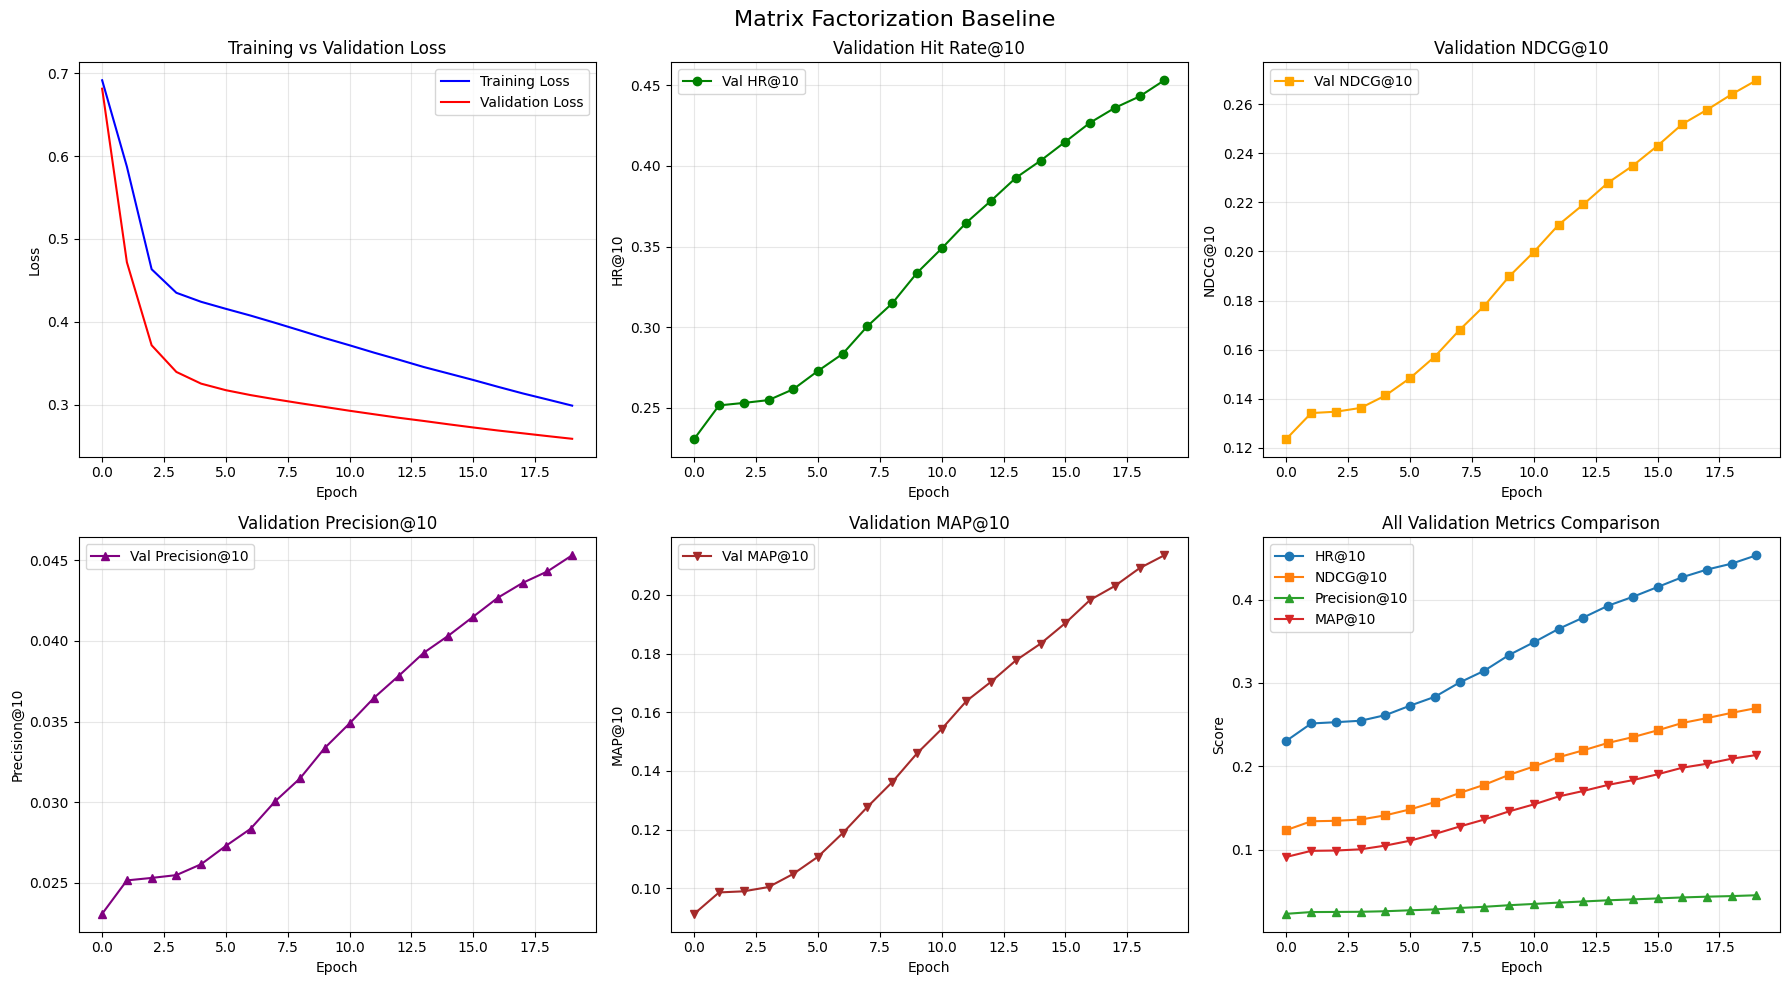

In [77]:
plot_training_history(
    train_losses,
    val_losses,
    val_metrics,
    k=10,
    model_name="Matrix Factorization Baseline",
    save_path="training_history.png"
)

## Model 1: Neural matrix factorization model

In [78]:
class NeuralMF(nn.Module):
    def __init__(
        self,
        n_users: int,
        n_items: int,
        gmf_dim: int = 32,
        mlp_dim: int = 32,
        mlp_layers=(64, 32, 16),
        dropout: float = 0.1,
        use_bias: bool = True,
    ):
        super().__init__()
        # GMF
        self.user_emb_gmf = nn.Embedding(n_users, gmf_dim)
        self.item_emb_gmf = nn.Embedding(n_items, gmf_dim)

        # MLP
        self.user_emb_mlp = nn.Embedding(n_users, mlp_dim)
        self.item_emb_mlp = nn.Embedding(n_items, mlp_dim)

        mlp_blocks = []
        in_dim = mlp_dim * 2
        for h in mlp_layers:
            mlp_blocks.append(nn.Linear(in_dim, h))
            mlp_blocks.append(nn.ReLU())
            if dropout and dropout > 0:
                mlp_blocks.append(nn.Dropout(dropout))
            in_dim = h
        self.mlp = nn.Sequential(*mlp_blocks) if mlp_blocks else nn.Identity()

        # Final combine
        final_in = gmf_dim + (mlp_layers[-1] if mlp_blocks else mlp_dim * 2)
        self.fc_out = nn.Linear(final_in, 1)

        self.use_bias = use_bias
        if use_bias:
            self.user_bias = nn.Embedding(n_users, 1)
            self.item_bias = nn.Embedding(n_items, 1)
        else:
            self.user_bias = None
            self.item_bias = None
        self.global_bias = nn.Parameter(torch.zeros(1))

        self._reset_parameters()

    def _reset_parameters(self):
        for emb in [self.user_emb_gmf, self.item_emb_gmf, self.user_emb_mlp, self.item_emb_mlp]:
            nn.init.xavier_uniform_(emb.weight)
        for m in self.mlp:
            if isinstance(m, nn.Linear):
                nn.init.xavier_uniform_(m.weight)
                nn.init.zeros_(m.bias)
        nn.init.xavier_uniform_(self.fc_out.weight)
        nn.init.zeros_(self.fc_out.bias)
        if self.use_bias:
            nn.init.zeros_(self.user_bias.weight)
            nn.init.zeros_(self.item_bias.weight)

    def forward(self, user_ids, item_ids):
        # GMF
        gmf_u = self.user_emb_gmf(user_ids)
        gmf_i = self.item_emb_gmf(item_ids)
        gmf   = gmf_u * gmf_i

        # MLP
        mlp_u = self.user_emb_mlp(user_ids)
        mlp_i = self.item_emb_mlp(item_ids)
        mlp   = torch.cat([mlp_u, mlp_i], dim=1)
        mlp   = self.mlp(mlp)

        # Combine
        x = torch.cat([gmf, mlp], dim=1)
        logit = self.fc_out(x).squeeze(-1)

        if self.use_bias:
            logit = logit + self.user_bias(user_ids).squeeze(-1) + self.item_bias(item_ids).squeeze(-1)
        logit = logit + self.global_bias
        return logit

    @torch.no_grad()
    def predict_all_items(self, user_id: int) -> torch.Tensor:
        device = next(self.parameters()).device
        u = torch.tensor([user_id], dtype=torch.long, device=device)
        all_items = torch.arange(self.item_emb_gmf.num_embeddings, dtype=torch.long, device=device)

        # GMF
        gmf_u = self.user_emb_gmf(u)
        gmf_i = self.item_emb_gmf(all_items)
        gmf   = (gmf_u * gmf_i)

        # MLP
        mlp_u = self.user_emb_mlp(u).expand(all_items.numel(), -1)
        mlp_i = self.item_emb_mlp(all_items)
        mlp   = torch.cat([mlp_u, mlp_i], dim=1)
        mlp   = self.mlp(mlp)

        x = torch.cat([gmf, mlp], dim=1)
        logit = self.fc_out(x).squeeze(-1)

        if self.use_bias:
            logit = logit + self.user_bias(u).squeeze(-1) + self.item_bias(all_items).squeeze(-1)
        logit = logit + self.global_bias
        return logit

In [79]:
neumf = NeuralMF(
    n_users=NUM_USERS,
    n_items=NUM_ITEMS,
    gmf_dim=32,
    mlp_dim=32,
    mlp_layers=(64, 32, 16),
    dropout=0.2,
    use_bias=True
).to(DEVICE)

loss_fn = nn.BCEWithLogitsLoss()
optimizer = torch.optim.Adam(neumf.parameters(), lr=1e-3, weight_decay=1e-6)

train_losses_neumf, val_losses_neumf, val_metrics_neumf, best_ndcg_neumf = model_trainer(
    model=neumf,
    train_loader=train_loader,
    eval_loader=val_loader,
    loss_fn=loss_fn,
    optimizer=optimizer,
    epochs=20,
    k=10,
    device=DEVICE,
    save_dir="model_neumf"
)

best_neumf = load_best_weights(neumf, ckpt_path="model_neumf/best_model.pth", device=DEVICE)
results_df_neumf = final_evaluation_loader(best_neumf, test_loader, loss_fn, device=DEVICE)

Evaluating: 100%|██████████| 6/6 [00:00<00:00, 18.51it/s]


Epoch 1/20  Train loss 0.4869  Val loss 0.2282  HR@10 0.2487  NDCG@10 0.1304  Precision@10 0.0249  MAP@10 0.0948  (new best)  Time 14.33s


Evaluating: 100%|██████████| 6/6 [00:00<00:00, 17.94it/s]


Epoch 2/20  Train loss 0.4326  Val loss 0.2224  HR@10 0.2614  NDCG@10 0.1388  Precision@10 0.0261  MAP@10 0.1018  (new best)  Time 14.08s


Evaluating: 100%|██████████| 6/6 [00:00<00:00, 19.91it/s]


Epoch 3/20  Train loss 0.4052  Val loss 0.2129  HR@10 0.3077  NDCG@10 0.1660  Precision@10 0.0308  MAP@10 0.1231  (new best)  Time 14.00s


Evaluating: 100%|██████████| 6/6 [00:00<00:00, 18.92it/s]


Epoch 4/20  Train loss 0.3716  Val loss 0.1984  HR@10 0.3561  NDCG@10 0.1987  Precision@10 0.0356  MAP@10 0.1509  (new best)  Time 13.99s


Evaluating: 100%|██████████| 6/6 [00:00<00:00, 18.59it/s]


Epoch 5/20  Train loss 0.3380  Val loss 0.1922  HR@10 0.3854  NDCG@10 0.2192  Precision@10 0.0385  MAP@10 0.1687  (new best)  Time 13.78s


Evaluating: 100%|██████████| 6/6 [00:00<00:00, 21.07it/s]


Epoch 6/20  Train loss 0.3070  Val loss 0.1903  HR@10 0.4002  NDCG@10 0.2319  Precision@10 0.0400  MAP@10 0.1806  (new best)  Time 13.90s


Evaluating: 100%|██████████| 6/6 [00:00<00:00, 18.92it/s]


Epoch 7/20  Train loss 0.2804  Val loss 0.1722  HR@10 0.4188  NDCG@10 0.2454  Precision@10 0.0419  MAP@10 0.1924  (new best)  Time 13.85s


Evaluating: 100%|██████████| 6/6 [00:00<00:00, 19.34it/s]


Epoch 8/20  Train loss 0.2571  Val loss 0.1693  HR@10 0.4215  NDCG@10 0.2479  Precision@10 0.0422  MAP@10 0.1948  (new best)  Time 13.92s


Evaluating: 100%|██████████| 6/6 [00:00<00:00, 18.70it/s]


Epoch 9/20  Train loss 0.2350  Val loss 0.1577  HR@10 0.4281  NDCG@10 0.2525  Precision@10 0.0428  MAP@10 0.1989  (new best)  Time 13.85s


Evaluating: 100%|██████████| 6/6 [00:00<00:00, 19.63it/s]


Epoch 10/20  Train loss 0.2167  Val loss 0.1605  HR@10 0.4277  NDCG@10 0.2529  Precision@10 0.0428  MAP@10 0.1994  (new best)  Time 14.65s


Evaluating: 100%|██████████| 6/6 [00:00<00:00, 19.22it/s]


Epoch 11/20  Train loss 0.2002  Val loss 0.1584  HR@10 0.4347  NDCG@10 0.2566  Precision@10 0.0435  MAP@10 0.2020  (new best)  Time 13.88s


Evaluating: 100%|██████████| 6/6 [00:00<00:00, 22.30it/s]


Epoch 12/20  Train loss 0.1860  Val loss 0.1499  HR@10 0.4373  NDCG@10 0.2599  Precision@10 0.0437  MAP@10 0.2056  (new best)  Time 13.59s


Evaluating: 100%|██████████| 6/6 [00:00<00:00, 19.08it/s]


Epoch 13/20  Train loss 0.1736  Val loss 0.1530  HR@10 0.4385  NDCG@10 0.2606  Precision@10 0.0438  MAP@10 0.2061  (new best)  Time 14.75s


Evaluating: 100%|██████████| 6/6 [00:00<00:00, 18.20it/s]


Epoch 14/20  Train loss 0.1630  Val loss 0.1511  HR@10 0.4378  NDCG@10 0.2596  Precision@10 0.0438  MAP@10 0.2051    Time 14.22s


Evaluating: 100%|██████████| 6/6 [00:00<00:00, 19.97it/s]


Epoch 15/20  Train loss 0.1540  Val loss 0.1442  HR@10 0.4428  NDCG@10 0.2649  Precision@10 0.0443  MAP@10 0.2104  (new best)  Time 13.86s


Evaluating: 100%|██████████| 6/6 [00:00<00:00, 22.15it/s]


Epoch 16/20  Train loss 0.1453  Val loss 0.1469  HR@10 0.4451  NDCG@10 0.2655  Precision@10 0.0445  MAP@10 0.2104  (new best)  Time 13.95s


Evaluating: 100%|██████████| 6/6 [00:00<00:00, 17.01it/s]


Epoch 17/20  Train loss 0.1385  Val loss 0.1462  HR@10 0.4410  NDCG@10 0.2650  Precision@10 0.0441  MAP@10 0.2110    Time 14.16s


Evaluating: 100%|██████████| 6/6 [00:00<00:00, 18.40it/s]


Epoch 18/20  Train loss 0.1325  Val loss 0.1425  HR@10 0.4429  NDCG@10 0.2658  Precision@10 0.0443  MAP@10 0.2113  (new best)  Time 14.16s


Evaluating: 100%|██████████| 6/6 [00:00<00:00, 21.74it/s]


Epoch 19/20  Train loss 0.1263  Val loss 0.1418  HR@10 0.4435  NDCG@10 0.2660  Precision@10 0.0443  MAP@10 0.2114  (new best)  Time 14.14s


Evaluating: 100%|██████████| 6/6 [00:00<00:00, 18.79it/s]


Epoch 20/20  Train loss 0.1219  Val loss 0.1413  HR@10 0.4424  NDCG@10 0.2661  Precision@10 0.0442  MAP@10 0.2118  (new best)  Time 14.33s

Training Complete.
Best epoch: 20 with NDCG@10: 0.2661



Evaluating: 100%|██████████| 6/6 [00:00<00:00, 30.15it/s]

     HR@K  NDCG@K  Precision@K
K                             
5  0.2690  0.1839       0.0538
10 0.3745  0.2178       0.0374
20 0.5093  0.2518       0.0255
50 0.7499  0.2993       0.0150


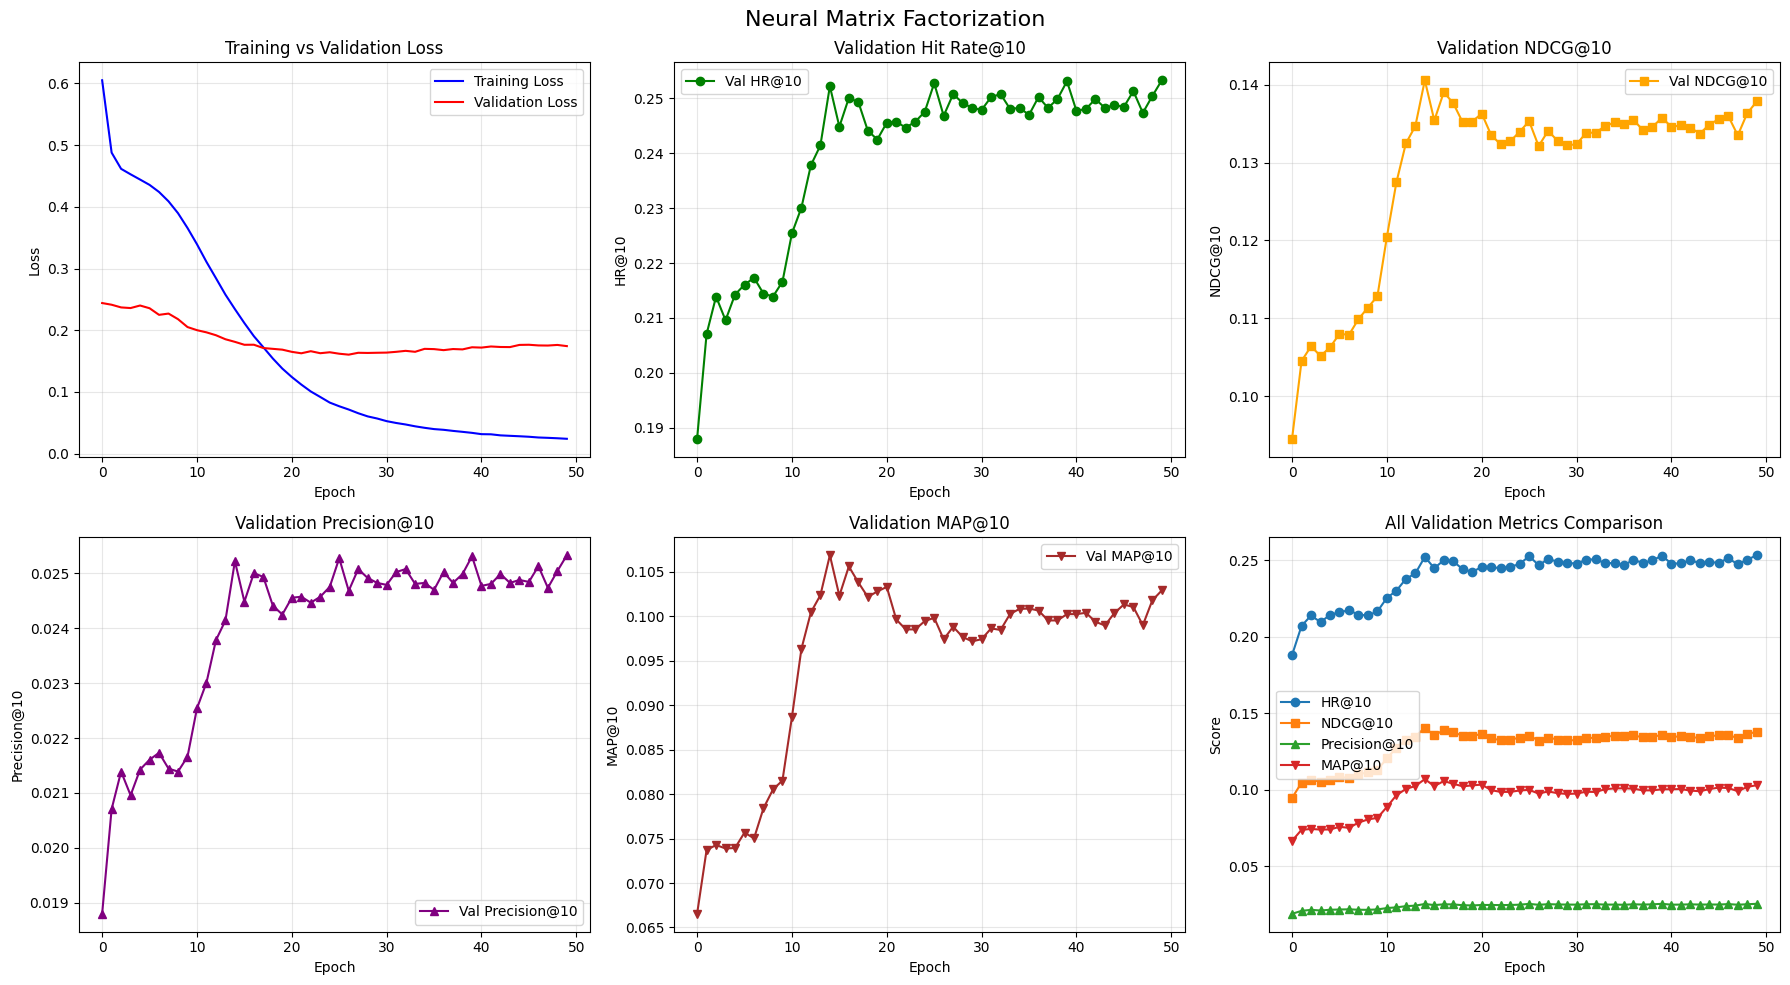

In [41]:
plot_training_history(
    train_losses_neumf,
    val_losses_neumf,
    val_metrics_neumf,
    k=10,
    model_name="Neural Matrix Factorization",
    save_path="training_history_neumf.png"
)

## Model 2: SASRec model
Transformer-based model for sequential recommendation from the paper [Self-Attentive Sequential Recommendation (2018)](https://arxiv.org/abs/1808.09781).

* **Data:** build per-user, time-sorted history sequences (left-padded to max length in batch). For training, use history -> next item triples + one negative per triples.
* **Model:** Item embeddings + positional embeddings -> Transformer encoder with causal mask. Take final position representation as the user's state and score candidate items by dot-product.
* **Eval:** Identical to the baseline using LOO setting.

In [42]:
# def create_user_sequences(df):
#     df_sorted = df.sort_values(["user_id", "timestamp"])
#     user_sequences = {}
#     user_seq_lens = []
#     for uid, group in df_sorted.groupby("user_id"):
#         items = group["item_id"].tolist()
#         if len(items) >= 3:  # Need at least 3 for train/val/test split
#             user_sequences[uid] = items
#             user_seq_lens.append(len(items))
#
#     print(f"Created sequences for {len(user_sequences)} users.")
#     print(f"Average sequence length: {np.mean(user_seq_lens):.2f}")
#     print(f"Max sequence length: {np.max(user_seq_lens)}")
#     print(f"Min sequence length: {np.min(user_seq_lens)}")
#
#     return {
#         "sequences": user_sequences,
#         "avg_seq_len": np.mean(user_seq_lens),
#         "num_users": len(user_sequences)
#     }
#
# def shift_label_encoder(df):
#     df_enc = df.copy()
#     user_enc = LabelEncoder()
#     item_enc = LabelEncoder()
#     df_enc["user_id"] = user_enc.fit_transform(df_enc["user"])
#     df_enc["item_id"] = item_enc.fit_transform(df_enc["item"])
#     df_enc["item_id"] = df_enc["item_id"] + 1  # reserve 0 for padding → SASRec item IDs are +1
#     return {"encoded_df": df_enc,
#             "user_encoder": user_enc,
#             "item_encoder": item_enc}
#
# class SASRecDataset(Dataset):
#     def __init__(self, user_sequences, num_items, max_seq_len=50, mode="train", neg_samples=1):
#         self.user_sequences = user_sequences
#         self.num_items = num_items
#         self.max_seq_len = max_seq_len
#         self.mode = mode
#         self.neg_samples = neg_samples
#         self.users = list(user_sequences.keys())
#
#         # Set of all items each user has interacted with
#         self.user_item_set = {u: set(items) for u, items in user_sequences.items()}
#
#         self.samples = []
#         for user, seq in user_sequences.items():
#             if len(seq) < 3:
#                 continue
#             if mode == "train":
#                 for t in range(1, len(seq) - 2):
#                     input_seq = seq[:t]
#                     target = seq[t]
#                     self.samples.append((user, input_seq, target))
#             elif mode == "val":
#                 input_seq = seq[:-2]
#                 target = seq[-2]
#                 self.samples.append((user, input_seq, target))
#             else:  # test
#                 input_seq = seq[:-1]
#                 target = seq[-1]
#                 self.samples.append((user, input_seq, target))
#
#     def __len__(self):
#         return len(self.samples)
#
#     def __getitem__(self, idx):
#         user, input_seq, target = self.samples[idx]
#         if len(input_seq) > self.max_seq_len:
#             input_seq = input_seq[-self.max_seq_len:]
#         pad = self.max_seq_len - len(input_seq)
#         input_seq = [0] * pad + input_seq
#
#         neg_items = self._sample_negatives(user)
#
#         return {
#             "user": user,
#             "input_seq": torch.tensor(input_seq, dtype=torch.long),
#             "target": torch.tensor(target, dtype=torch.long), # target is a single item
#             "neg_items": torch.tensor(neg_items, dtype=torch.long)
#         }
#
#     def _sample_negatives(self, user):
#         # Negative sampling: sample items not in user's history
#         neg_items = set()
#         user_items = self.user_item_set[user]
#         while len(neg_items) < self.neg_samples:
#             neg = random.randint(1, self.num_items - 1)
#             if neg not in user_items:
#                 neg_items.add(neg)
#         return list(neg_items)
#
# sasrec_encoder = shift_label_encoder(filtered_df)
# df_encoded_sasrec = sasrec_encoder["encoded_df"]
#
# train_df_sasrec, val_df_sasrec, test_df_sasrec = loo_split(df_encoded_sasrec)
#
# SASREC_NUM_USERS = int(df_encoded_sasrec["user_id"].max()) + 1  # user IDs start at 0
# SASREC_NUM_ITEMS = int(df_encoded_sasrec["item_id"].max()) + 1  # item IDs start at 1, 0 is padding
#
# # Only keep users present in each split
# train_users_sasrec = set(train_df_sasrec["user_id"].unique())
# val_users_sasrec = set(val_df_sasrec["user_id"].unique())
# test_users_sasrec = set(test_df_sasrec["user_id"].unique())
#
# # Filter user sequences to match the splits
# user_sequences = create_user_sequences(df_encoded_sasrec)
# train_sequences = {u: seq for u, seq in user_sequences["sequences"].items() if u in train_users_sasrec}
# val_sequences = {u: seq for u, seq in user_sequences["sequences"].items() if u in val_users_sasrec}
# test_sequences = {u: seq for u, seq in user_sequences["sequences"].items() if u in test_users_sasrec}
#
# # train_sequences = {u: seq for u, seq in user_sequences["sequences"].items() if u in train_users_sasrec}
# # val_sequences = {u: seq for u, seq in user_sequences["sequences"].items() if u in train_users_sasrec}
# # test_sequences = {u: seq for u, seq in user_sequences["sequences"].items() if u in train_users_sasrec}
#
# # train_sequences = {u: seq[:-2] for u, seq in user_sequences["sequences"].items() if len(seq) >= 3}
# # val_sequences   = {u: seq[:] for u, seq in user_sequences["sequences"].items() if len(seq) >= 3}
# # test_sequences  = {u: seq[:] for u, seq in user_sequences["sequences"].items() if len(seq) >= 3}
#
# print("\n")
# print(f"Train sequences: {len(train_sequences)} users")
# print(f"Validation sequences: {len(val_sequences)} users")
# print(f"Test sequences: {len(test_sequences)} users")

In [43]:
# train_dataset_sasrec = SASRecDataset(train_sequences, num_items=SASREC_NUM_ITEMS, max_seq_len=50, mode="train", neg_samples=1)
# val_dataset_sasrec = SASRecDataset(val_sequences, num_items=SASREC_NUM_ITEMS, max_seq_len=50, mode="val", neg_samples=99)
# test_dataset_sasrec = SASRecDataset(test_sequences, num_items=SASREC_NUM_ITEMS, max_seq_len=50, mode="test", neg_samples=99)
#
# train_loader_sasrec = DataLoader(train_dataset_sasrec, batch_size=4096, shuffle=True)
# val_loader_sasrec = DataLoader(val_dataset_sasrec, batch_size=4096, shuffle=False)
# test_loader_sasrec = DataLoader(test_dataset_sasrec, batch_size=4096, shuffle=False)

In [44]:
# first = next(iter(val_loader_sasrec))
# print("Sample batch from validation loader:")
# print("Input sequence shape:", first["input_seq"].shape)
# print("Target shape:", first["target"].shape)
# print("Negative items shape:", first["neg_items"].shape)
#
# print("\nSample input sequence:")
# for i in range(2):
#     print(first["input_seq"][i].tolist())

### Building the model

In [45]:
# # Building SASRec model
# class PointWiseFeedForward(nn.Module):
#     def __init__(self, hidden_dim, dropout=0.2):
#         super().__init__()
#         self.w1 = nn.Linear(hidden_dim, hidden_dim)
#         self.w2 = nn.Linear(hidden_dim, hidden_dim)
#         self.relu = nn.ReLU()
#         self.dropout = nn.Dropout(dropout)
#
#     def forward(self, x):
#         return self.w2(self.dropout(self.relu(self.w1(x))))
#
# class AttentionBlock(nn.Module):
#     def __init__(self, hidden_dim, num_heads, dropout=0.2):
#         super().__init__()
#
#         # Multi-head attention
#         self.attn = nn.MultiheadAttention(hidden_dim, num_heads, dropout=dropout, batch_first=True)
#
#         # Layer norms
#         self.ln1 = nn.LayerNorm(hidden_dim)
#         self.ln2 = nn.LayerNorm(hidden_dim)
#
#         # Feed-forward network
#         self.ffn = PointWiseFeedForward(hidden_dim, dropout)
#         self.dropout = nn.Dropout(dropout)
#
#     def forward(self, x, attn_mask=None):
#         # Self-attention with residual connection
#         attn_out, _ = self.attn(x, x, x, attn_mask=attn_mask)
#         x = self.ln1(x + self.dropout(attn_out))
#
#         # Feed-forward network with residual connection
#         ffn_out = self.ffn(x)
#         x = self.ln2(x + self.dropout(ffn_out))
#
#         return x
#
# class SASRec(nn.Module):
#     def __init__(self,
#                  num_items,
#                  hidden_dim=64,
#                  max_seq_len=50,
#                  num_blocks=2,
#                  num_heads=2,
#                  dropout=0.2):
#         super().__init__()
#
#         self.num_items = num_items
#         self.hidden_dim = hidden_dim
#         self.max_seq_len = max_seq_len
#
#         # Embedding layers
#         self.item_embed = nn.Embedding(num_items, hidden_dim, padding_idx=0)
#         self.positional_embed = nn.Embedding(max_seq_len, hidden_dim)
#         self.dropout = nn.Dropout(dropout)
#
#         # Stack of SASRec blocks
#         self.blocks = nn.ModuleList([
#             AttentionBlock(hidden_dim, num_heads, dropout) for _ in range(num_blocks)
#         ])
#
#         # Final layer norm
#         self.ln = nn.LayerNorm(hidden_dim)
#
#         # Initialize weights
#         self._reset_parameters()
#
#     def _reset_parameters(self):
#         nn.init.xavier_normal_(self.item_embed.weight[1:])  # Skip padding idx
#         nn.init.xavier_normal_(self.positional_embed.weight)
#
#     def forward(self, input_seq, candidate_items=None):
#         batch_size, seq_len = input_seq.shape
#
#         # Get item embeddings
#         item_embeds = self.item_embed(input_seq)  # [B, L, D]
#
#         # Add positional embeddings
#         positions = torch.arange(seq_len, device=input_seq.device).unsqueeze(0)
#         pos_embeds = self.positional_embed(positions)  # [1, L, D]
#         x = self.dropout(item_embeds + pos_embeds)
#
#         # Create causal attention mask
#         attn_mask = self._create_causal_mask(seq_len, input_seq.device)
#         pad_mask = input_seq.eq(0)
#
#         # Pass through transformer blocks
#         for block in self.blocks:
#             x = block(x, attn_mask=attn_mask)
#
#         # Final layer norm
#         x = self.ln(x)  # [B, L, D]
#         x = x.masked_fill(pad_mask.unsqueeze(-1), 0.0)
#
#         # If candidate_items provided, score them
#         if candidate_items is not None:
#             # Get embeddings for candidate items
#             cand_emb = self.item_embed(candidate_items) # [B, N, D]
#
#             # Use last position's representation for scoring
#             last_hidden = x[:, -1, :].unsqueeze(1)  # [B, 1, D]
#
#             # Compute scores via dot product
#             scores = torch.matmul(last_hidden, cand_emb.transpose(1, 2)).squeeze(1) # [B, N]
#             return scores
#
#         return x
#
#     def _create_causal_mask(self, seq_len, device):
#         mask = torch.triu(torch.ones(seq_len, seq_len, device=device, dtype=torch.bool), diagonal=1)
#         mask = mask.masked_fill(mask == 1, float("-inf"))
#         return mask
#
#     def predict_next(self, input_seq):
#         # Get sequence representations
#         seq_repr = self.forward(input_seq)  # [B, L, D]
#
#         # Use last position for prediction
#         last_hidden = seq_repr[:, -1, :]  # [B, D]
#
#         # Score against all item embeddings
#         all_item_embeds = self.item_embed.weight  # [num_items, D]
#         scores = torch.matmul(last_hidden, all_item_embeds.T)  # [B, num_items]
#         return scores

### Training the SASRec model

In [46]:
# def train_sasrec_epoch(model, train_loader, loss_fn, optimizer, device="cpu"):
#     model.train()
#     total_loss = 0.0
#     n_batches = 0
#
#     for batch in tqdm(train_loader, desc="Training"):
#         input_seq = batch["input_seq"].to(device)
#         pos_items = batch["target"].to(device)
#         neg_items = batch["neg_items"].to(device)
#
#         # Get predictions for last position
#         seq_output = model(input_seq)  # [B, L, D]
#         last_hidden = seq_output[:, -1, :]  # [B, D]
#
#         # Get embeddings for positive and negative items
#         pos_embeds = model.item_embed(pos_items)
#         neg_embeds = model.item_embed(neg_items)
#
#         # Compute logits
#         pos_logits = (last_hidden * pos_embeds).sum(dim=1)
#         neg_logits = torch.bmm(neg_embeds, last_hidden.unsqueeze(-1)).squeeze(-1)
#
#         # Binary cross-entropy loss with logits
#         pos_labels = torch.ones_like(pos_logits)
#         neg_labels = torch.zeros_like(neg_logits)
#
#         # Concatenate logits and labels
#         all_logits = torch.cat([pos_logits.unsqueeze(1), neg_logits], dim=1)
#         all_labels = torch.cat([pos_labels.unsqueeze(1), neg_labels], dim=1)
#
#         loss = loss_fn(all_logits, all_labels)
#
#         optimizer.zero_grad()
#         loss.backward()
#         optimizer.step()
#         total_loss += loss.item()
#         n_batches += 1
#
#     return total_loss / n_batches
#
# # Validation loss and ranking metrics
# @torch.no_grad()
# def evaluate_sasrec(model, eval_loader, loss_fn, k=10, device="cpu"):
#     model.eval()
#     total = 0
#     sum_hr = 0.0
#     sum_ndcg = 0.0
#     sum_prec = 0.0
#     sum_ap = 0.0
#
#     sum_val_loss = 0.0
#     n_loss_batches = 0
#
#     for batch in tqdm(eval_loader, desc="Evaluating"):
#         input_seq = batch["input_seq"].to(device)
#         target = batch["target"].to(device)
#         neg_items = batch["neg_items"].to(device)
#
#         batch_size = input_seq.size(0)
#
#         # Create candidate set: 1 positive + negatives
#         seq_output = model(input_seq)  # [B, L, D]
#         last_hidden = seq_output[:, -1, :]  # [B, D]
#         candidates = torch.cat([
#             target.unsqueeze(1),  # [B, 1]
#             neg_items  # [B, neg_samples]
#         ], dim=1)  # [B, 1 + neg_samples]
#
#         # Get embeddings for all candidates
#         cand_emb = model.item_embed(candidates)  # [B, 1+neg_samples, D]
#
#         # Compute scores via dot product
#         scores = torch.bmm(cand_emb, last_hidden.unsqueeze(-1)).squeeze(-1)  # [B, 1+neg_samples]
#
#         # Loss calculation
#         pos_scores = scores[:, 0]
#         neg_scores = scores[:, 1:]
#         pos_labels = torch.ones_like(scores[:, 0])
#         neg_labels = torch.zeros_like(scores[:, 1:])
#         all_scores = torch.cat([pos_scores.unsqueeze(1), neg_scores], dim=1)
#         all_labels = torch.cat([pos_labels.unsqueeze(1), neg_labels], dim=1)
#         batch_loss = loss_fn(all_scores.reshape(-1), all_labels.reshape(-1))
#         sum_val_loss += batch_loss.item()
#         n_loss_batches += 1
#
#         # Calculate metrics
#         _, full_idx = torch.sort(scores, dim=1, descending=True)
#         rank = (full_idx == 0).nonzero(as_tuple=True)[1] + 1  # Rank of the positive item (1-based)
#
#         hit = (rank <= k).float()
#         ndcg = torch.where(rank <= k, 1.0 / torch.log2(rank.float() + 1), torch.zeros_like(hit))
#         precision = hit / float(k)
#         ap = torch.where(rank <= k, 1.0 / rank.float(), torch.zeros_like(hit))
#
#         sum_hr += hit.sum().item()
#         sum_ndcg += ndcg.sum().item()
#         sum_prec += precision.sum().item()
#         sum_ap += ap.sum().item()
#         total += batch_size
#
#     metrics = {
#         "HR@K": sum_hr / total if total else 0.0,
#         "NDCG@K": sum_ndcg / total if total else 0.0,
#         "Precision@K": sum_prec / total if total else 0.0,
#         "MAP@K": sum_ap / total if total else 0.0,
#         "Val loss": sum_val_loss / max(n_loss_batches, 1)
#     }
#
#     return metrics

In [47]:
# def sasrec_trainer(
#         model,
#         train_loader,
#         eval_loader,
#         epochs,
#         loss_fn,
#         optimizer,
#         k=10,
#         device="cpu",
#         save_dir="model"
#     ):
#     os.makedirs(save_dir, exist_ok=True)
#     model.to(device)
#     writer = SummaryWriter()
#
#     train_losses, val_losses, val_metrics_log = [], [], []
#     best_ndcg, best_epoch = 0.0, 0
#
#     for epoch in range(epochs):
#         t0 = time.time()
#
#         # Train (batched)
#         train_loss = train_sasrec_epoch(model, train_loader, loss_fn, optimizer, device=device)
#         train_losses.append(train_loss)
#
#         # Eval (batched)
#         m = evaluate_sasrec(model, eval_loader, loss_fn, k=k, device=device)
#         val_losses.append(m["Val loss"])
#         val_metrics_log.append({k_: m[k_] for k_ in ["HR@K", "NDCG@K", "Precision@K", "MAP@K"]})
#
#         # Checkpointing by NDCG
#         if m["NDCG@K"] > best_ndcg:
#             best_ndcg = m["NDCG@K"]
#             best_epoch = epoch + 1
#             torch.save(model.state_dict(), os.path.join(save_dir, "best_model.pth"))
#         torch.save(model.state_dict(), os.path.join(save_dir, "last_model.pth"))
#
#         # TB logs
#         writer.add_scalar("Loss/Train", train_loss, epoch)
#         writer.add_scalar("Loss/Validation", m["Val loss"], epoch)
#         writer.add_scalar(f"Metrics/Val_HR@{k}", m["HR@K"], epoch)
#         writer.add_scalar(f"Metrics/Val_NDCG@{k}", m["NDCG@K"], epoch)
#         writer.add_scalar(f"Metrics/Val_Precision@{k}", m["Precision@K"], epoch)
#         writer.add_scalar(f"Metrics/Val_MAP@{k}", m["MAP@K"], epoch)
#
#         print(
#             f"Epoch {epoch+1}/{epochs}  "
#             f"Train loss {train_loss:.4f}  "
#             f"Val loss {m['Val loss']:.4f}  "
#             f"HR@{k} {m['HR@K']:.4f}  "
#             f"NDCG@{k} {m['NDCG@K']:.4f}  "
#             f"Precision@{k} {m['Precision@K']:.4f}  "
#             f"MAP@{k} {m['MAP@K']:.4f}  "
#             f"{'(new best)' if m['NDCG@K'] == best_ndcg and best_epoch==epoch+1 else ''}  "
#             f"Time {time.time()-t0:.2f}s"
#         )
#
#     # print("\n" + "="*50)
#     print("\nTraining Complete.")
#     print(f"Best epoch: {best_epoch} with NDCG@{k}: {best_ndcg:.4f}\n")
#     # print("="*50)
#     # print("\n")
#
#     gc.collect()
#     if torch.cuda.is_available():
#         torch.cuda.empty_cache()
#     writer.close()
#     return train_losses, val_losses, val_metrics_log, best_ndcg

In [48]:
# # Hyperparameters from the original paper, except higher hidden_dim
# sasrec = SASRec(
#     num_items=SASREC_NUM_ITEMS,
#     hidden_dim=64,
#     max_seq_len=50,
#     num_blocks=2,
#     num_heads=2,
#     dropout=0.5
# )
#
# loss_fn_sasrec = nn.BCEWithLogitsLoss()
# optimizer_sasrec = torch.optim.Adam(sasrec.parameters(), lr=1e-3, weight_decay=1e-6)
#
# train_losses_sasrec, val_losses_sasrec, val_metrics_sasrec, best_ndcg_sasrec = sasrec_trainer(
#     model=sasrec,
#     train_loader=train_loader_sasrec,
#     eval_loader=val_loader_sasrec,
#     loss_fn=loss_fn_sasrec,
#     optimizer=optimizer_sasrec,
#     epochs=50,
#     k=10,
#     device=DEVICE,
#     save_dir="model_sasrec"
# )

### Final evaluation on test set

In [49]:
# best_sasrec = load_best_weights(sasrec, ckpt_path="model_sasrec/best_model.pth", device=DEVICE)

In [50]:
# # Final evaluation on test set
# @torch.no_grad()
# def final_evaluation_sasrec(model, test_loader, loss_fn, k_values=(5,10,20,50), device="cpu") -> pd.DataFrame:
#     rows = []
#     for k in k_values:
#         metrics = evaluate_sasrec(model, test_loader, loss_fn, k=k, device=device)
#         rows.append({
#             "K": k,
#             "HR@K": metrics["HR@K"],
#             "NDCG@K": metrics["NDCG@K"],
#             "Precision@K": metrics["Precision@K"],
#         })
#     df = pd.DataFrame(rows).set_index("K").sort_index()
#     print(df.to_string(float_format=lambda x: f"{x:.4f}"))
#     return df
#
# results_df_sasrec = final_evaluation_sasrec(best_sasrec, test_loader_sasrec, loss_fn_sasrec, device=DEVICE)

In [51]:
# @torch.no_grad()
# def get_recommendations_sasrec(
#         model,
#         user_id,
#         input_seq,
#         pos_items_by_user,
#         item_encoder,
#         top_k=10,
#         exclude_interacted=True,
#         device="cpu"):
#
#     model.eval()
#
#     if len(input_seq) > model.max_seq_len:
#         processed_seq = input_seq[-model.max_seq_len:]
#     elif len(input_seq) < model.max_seq_len:
#         processed_seq = [0] * (model.max_seq_len - len(input_seq)) + input_seq
#     else:
#         processed_seq = input_seq
#
#     input_tensor = torch.tensor([processed_seq], dtype=torch.long, device=device)
#     scores = model.predict_next(input_tensor).squeeze(0)
#
#     # Exclude items the user has already interacted with
#     if exclude_interacted and user_id in pos_items_by_user:
#         interacted_indices = torch.as_tensor(
#             list(pos_items_by_user[user_id]),
#             dtype=torch.long,
#             device=device
#         )
#         if interacted_indices.numel() > 0:
#             scores.index_fill_(0, interacted_indices, float("-inf"))
#
#     top_scores, top_indices = torch.topk(scores, top_k)
#     item_ids_np = top_indices.detach().cpu().numpy()
#     items_np = item_encoder.inverse_transform(item_ids_np)
#
#     return [
#         {"item_id": int(i), "item": it, "score": float(s)}
#         for i, it, s in zip(item_ids_np, items_np, top_scores.detach().cpu().numpy())
#     ]

In [52]:
# def show_sample_recommendations_sasrec(
#     model,
#     df,
#     user_encoder,
#     item_encoder,
#     pos_items_by_user,    # Used for filtering recommendations
#     history_by_user,      # Used to get the input sequence for the model
#     device,
#     num_users=5,
#     top_k=10):
#
#     print("\n" + "="*50)
#     print("SASRec - User Sample Recommendations")
#     print("="*50)
#
#     user_candidates = df["user_id"].unique().tolist()
#     num_to_sample = min(num_users, len(user_candidates))
#
#     for user_id in random.sample(user_candidates, k=num_to_sample):
#         original_user = user_encoder.inverse_transform([user_id])[0]
#         print(f"\nUser: {original_user} (ID: {user_id})")
#         print("-" * 40)
#
#         # Get the user's interaction history to show and to use as model input
#         user_history_seq = history_by_user.get(user_id, [])
#
#         # Display the 5 most recent interactions
#         recent_interactions = user_history_seq[-5:]
#         print("Recent interactions (most recent first):")
#         for item_id in reversed(recent_interactions):
#             item_name = item_encoder.inverse_transform([item_id])[0]
#             print(f"  - {item_name} (ID: {item_id})")
#
#         # Get recommendations using the adapted function
#         recs = get_recommendations_sasrec(
#             model=model,
#             user_id=user_id,
#             input_seq=user_history_seq, # Pass the full history as input
#             pos_items_by_user=pos_items_by_user,
#             item_encoder=item_encoder,
#             device=device,
#             top_k=top_k,
#             exclude_interacted=True
#         )
#
#         print("\nTop 10 Recommendations:")
#         for i, rec in enumerate(recs, 1):
#             print(f"  {i}. {rec['item']} (ID: {rec['item_id']}, Score: {rec['score']:.4f})")

In [53]:
# show_sample_recommendations_sasrec(
#     model=best_sasrec,
#     df=df_encoded,
#     user_encoder=user_enc,
#     item_encoder=item_enc,
#     pos_items_by_user=pos_items_by_user,
#     history_by_user=history_by_user_train,
#     device=DEVICE,
#     num_users=5,
#     top_k=10
# )

In [54]:
# plot_training_history(
#     train_losses_sasrec,
#     val_losses_sasrec,
#     val_metrics_sasrec,
#     k=10,
#     model_name="SASRec",
#     save_path="training_history_sasrec.png"
# )

## Comparison of all three models

In [55]:
# # Plot metrics comparison at different K values
# def plot_comparison(results_list, model_names, metric="NDCG@K", save_path="model_comparison.png"):
#     plt.figure(figsize=(8, 6))
#     for results, name in zip(results_list, model_names):
#         plt.plot(results.index, results[metric], marker='o', label=name)
#     plt.title(f"Comparison of {metric} Across Models in a Single Domain")
#     plt.xlabel("K")
#     plt.ylabel(metric)
#     plt.xticks(results_list[0].index)
#     plt.legend()
#     plt.grid(True)
#     plt.savefig(save_path)
#     plt.show()

In [56]:
# results_list = [results_df_mf, results_df_neumf, results_df_sasrec]
# model_names = ["MF (Baseline)", "NeuMF", "SASRec"]
# plot_comparison(results_list, model_names, metric="NDCG@K", save_path="ndcg_comparison.png")